<a href="https://colab.research.google.com/github/desve/vk-text-to-image-demo/blob/main/04_service_layer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1. Установка и импорт

In [1]:
!pip install -q diffusers transformers accelerate safetensors

import torch
from diffusers import StableDiffusionXLPipeline
from PIL import Image
import io, os

# 2. Инициализация модели

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Device:", device)

pipe = StableDiffusionXLPipeline.from_pretrained(
    "stabilityai/stable-diffusion-xl-base-1.0",
    torch_dtype=torch.float16 if device == "cuda" else torch.float32
).to(device)

pipe.enable_attention_slicing()

Device: cuda


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model_index.json:   0%|          | 0.00/609 [00:00<?, ?B/s]

Fetching 19 files:   0%|          | 0/19 [00:00<?, ?it/s]

config.json:   0%|          | 0.00/575 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/737 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/565 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/472 [00:00<?, ?B/s]

scheduler_config.json:   0%|          | 0.00/479 [00:00<?, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

text_encoder_2/model.safetensors:   0%|          | 0.00/2.78G [00:00<?, ?B/s]

text_encoder/model.safetensors:   0%|          | 0.00/492M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/460 [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

tokenizer_config.json:   0%|          | 0.00/725 [00:00<?, ?B/s]

config.json: 0.00B [00:00, ?B/s]

config.json:   0%|          | 0.00/642 [00:00<?, ?B/s]

unet/diffusion_pytorch_model.safetensors:   0%|          | 0.00/10.3G [00:00<?, ?B/s]

vae/diffusion_pytorch_model.safetensors:   0%|          | 0.00/335M [00:00<?, ?B/s]

vae_1_0/diffusion_pytorch_model.safetens(…):   0%|          | 0.00/335M [00:00<?, ?B/s]

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

`torch_dtype` is deprecated! Use `dtype` instead!


# 3. Базовые стили и промпты

In [3]:
styles = {
    "neutral": "digital illustration, soft lighting",
    "vk_flat": "flat illustration, clean lines, blue and violet colors",
    "neon": "neon cyberpunk style, glowing edges, high contrast",
    "experimental": "3d render, isometric view, minimalistic shapes"
}

main_styles = ["vk_flat", "neon"]

base_prompts = {
    "Самопрезентация": (
        "one young AI engineer on stage with microphone, "
        "big screen behind showing neural network diagram, tech conference"
    ),
    "Профессиональное достижение": (
        "data scientist working late at night in a modern office, "
        "only monitor light and city lights outside window, charts and neural networks on screens"
    ),
    "Команда VK": (
        "three interns in a modern IT office, sitting around a round table with laptops and sticky notes, "
        "warm friendly atmosphere"
    )
}
def build_prompt(base: str, style_key: str) -> str:
    style_tail = styles.get(style_key, "")
    if style_tail:
        return f"{base}, {style_tail}"
    return base

In [4]:
def generate_one(
    prompt: str,
    steps: int = 25,
    guidance: float = 7.5,
    height: int = 512,
    width: int = 512,
):
    result = pipe(
        prompt=prompt,
        num_inference_steps=steps,
        guidance_scale=guidance,
        height=height,
        width=width,
    )
    return result.images[0]

# Проверяем пайплайн SDXL

  0%|          | 0/20 [00:00<?, ?it/s]

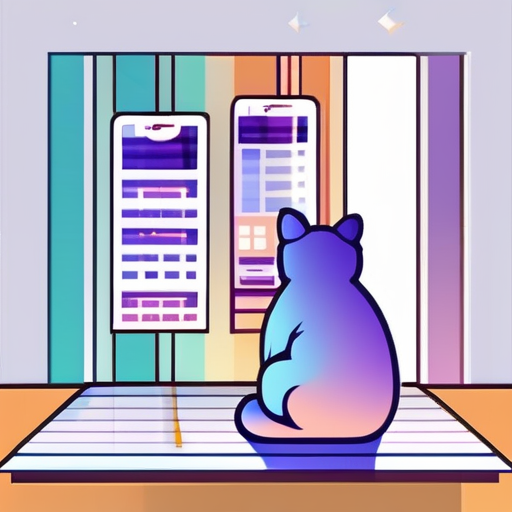

In [5]:
prompt = "young developer presenting a pet project on stage, flat illustration, blue and violet colors"
image = pipe(
    prompt=prompt,
    num_inference_steps=20,
    guidance_scale=7.5,
    height=512,
    width=512,
).images[0]
image

# Заглушка перевода и сборщик сцены

In [7]:
def translate_to_english(text: str) -> str:
    if text is None:
        return ""
    text = text.strip()
    if not text:
        return ""
    return text

def build_scene_prompt(scene_name: str, user_text: str | None = None) -> str:
    user_text = (user_text or "").strip()
    user_text_en = translate_to_english(user_text) if user_text else ""

    if scene_name == "Свободный текст":
        if user_text_en:
            return user_text_en
        return "abstract illustration of career, technology and collaboration"

    base_en = base_prompts.get(scene_name, "")
    if user_text_en:
        return f"{base_en}, {user_text_en}"
    return base_en

# Верхнеуровневая функция для будущего UI

In [8]:
def generate_image_for_app(
    scene_name: str,
    style_key: str,
    user_text: str,
    steps: int = 25,
    guidance: float = 7.5,
    height: int = 512,
    width: int = 512,
):
    base_prompt = build_scene_prompt(scene_name, user_text)
    full_prompt = build_prompt(base_prompt, style_key)
    img = generate_one(
        full_prompt,
        steps=steps,
        guidance=guidance,
        height=height,
        width=width,
    )
    return img

# Мини‑тест generate_image_for_app

The following part of your input was truncated because CLIP can only handle sequences up to 77 tokens: ['and violet colors']
The following part of your input was truncated because CLIP can only handle sequences up to 77 tokens: ['and violet colors']


  0%|          | 0/20 [00:00<?, ?it/s]

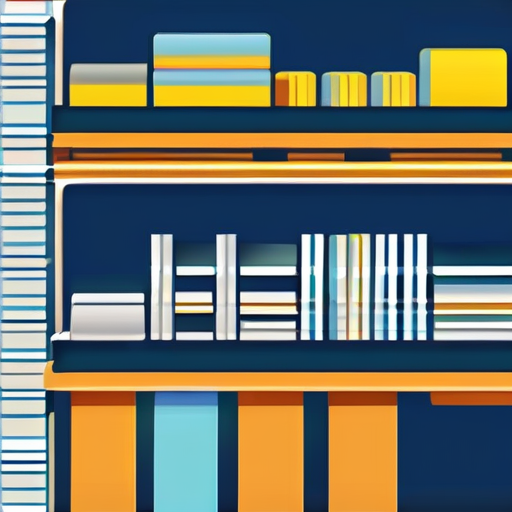

In [10]:
test_img = generate_image_for_app(
    scene_name="Самопрезентация",
    style_key="vk_flat",
    user_text="я выступаю на сцене с пет‑проектом про рекомендательную систему",
    steps=20,
    guidance=7.5,
    height=512,
    width=512,
)
test_img

Последняя ячейка для проверки:

The following part of your input was truncated because CLIP can only handle sequences up to 77 tokens: ['and violet colors']
The following part of your input was truncated because CLIP can only handle sequences up to 77 tokens: ['and violet colors']


  0%|          | 0/20 [00:00<?, ?it/s]

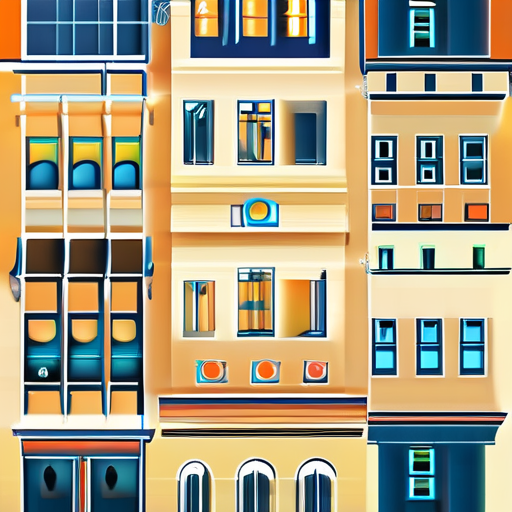

In [11]:
test_img = generate_image_for_app(
    scene_name="Самопрезентация",
    style_key="vk_flat",
    user_text="я выступаю на сцене с пет‑проектом про рекомендательную систему",
    steps=20,
    guidance=7.5,
    height=512,
    width=512,
)
test_img